# A COVID-19 Question Answering System

# Notebook Setup

## Installs

In [ ]:
%%capture 
# install hugging face transformers
! pip install -U sentence-transformers

## Imports

In [ ]:
# useful python utilities
import os, json, glob, re

# useful python libraries for ML/DL 
import numpy as np, time
import pandas as pd
import torch

# computing distance between vectors
from scipy.spatial.distance import cdist 

# notebook utilities
from IPython.display import display, HTML
import warnings
warnings.filterwarnings('ignore') 

from tqdm import tqdm 

In [ ]:
%%capture
# natural language processing libraries
import nltk
from nltk import word_tokenize
from nltk.corpus import stopwords
nltk.download("punkt")
nltk.download('stopwords')

from textblob import TextBlob

In [ ]:
# visualization libraries
import seaborn as sns
sns.set(rc={'figure.figsize':(10,10)})
import matplotlib.pyplot as plt
%matplotlib inline
from wordcloud import WordCloud as wc
from PIL import Image
import cv2

In [ ]:
#  dimensionality reduction and cluster analysis
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.feature_extraction.text import TfidfVectorizer

# BERT model and BERT tokenizer
from transformers import BertForQuestionAnswering
from transformers import BertTokenizer

# question-answering pipeline module API
from transformers import pipeline

# library tokenize sentences 
from sentence_transformers import SentenceTransformer

# Data Processing and Exploration

## Processing

In [ ]:
# load the dataset
df_covid = pd.read_csv('covidCleaned.csv')

In [ ]:
#View the first 5 rows in the data
df_covid.head()

,Unnamed: 0,paper_id,body_text,ref_entries,cord_uid,source_x,doi,pmcid,pubmed_id,license,publish_time,authors,journal,mag_id,who_covidence_id,arxiv_id,pdf_json_files,pmc_json_files,url,s2_id,title,abstract
0,0,000122a9a774ec76fa35ec0c0f6734e7e8d0c541,<SECTION>\n\nIntroduction and objectives: The ...,"Patient flowchart. NSTEMI, non-ST-segment elev...",7xtb3rtg,Elsevier; Medline; PMC,10.1016/j.rec.2020.08.002,PMC7834732,32917566,no-cc,2020-09-08,"Rodríguez-Leor, Oriol; Cid-Álvarez, Belén; Pér...",Rev Esp Cardiol (Engl Ed),NaN,NaN,NaN,document_parses/pdf_json/000122a9a774ec76fa35e...,document_parses/pmc_json/PMC7834732.xml.json,https://www.sciencedirect.com/science/article/...,221636866.0,Impact of COVID-19 on ST-segment elevation myo...,INTRODUCTION AND OBJECTIVES: The COVID-19 outb...
1,1,00031cc15aafa30b187ed2cd3790e970e5046895,"<SECTION>\n\nincreased serum creatinine, varia...",SARS-CoV-2 binding with angiotensin-converting...,n68m9jgn,PMC,10.1159/000512683,PMC7705946,NaN,cc-by-nc,2020-11-16,"Wang, Mo; Xiong, Huaying; Chen, Han; Li, Qiu; ...",Kidney Dis (Basel),NaN,NaN,NaN,document_parses/pdf_json/00031cc15aafa30b187ed...,document_parses/pmc_json/PMC7705946.xml.json,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC7...,NaN,Renal Injury by SARS-CoV-2 Infection: A System...,BACKGROUND: SARS-CoV-2 infection can cause ren...
2,2,00033d5a12240a8684cfe943954132b43434cf48,<SECTION>\nIntroduction\nSevere acute respirat...,Examples for a positive and negative rRT-PCR r...,eyky34fd,Medline; PMC,10.3390/v12080849,PMC7472307,32759673,cc-by,2020-08-04,"Wandernoth, Petra; Kriegsmann, Katharina; Groh...",Viruses,NaN,NaN,NaN,document_parses/pdf_json/00033d5a12240a8684cfe...,document_parses/pmc_json/PMC7472307.xml.json,https://www.ncbi.nlm.nih.gov/pubmed/32759673/;...,221491053.0,Detection of Severe Acute Respiratory Syndrome...,Background: Amplification of viral ribonucleic...
3,3,00035ac98d8bc38fbca02a1cc957f55141af67c0,<SECTION>\nINTRODUCTION\nSince the end of 2019...,Flowchart of the recruitment of the patients a...,d5kiogmn,Medline; PMC,10.3389/fpsyt.2020.559701,PMC7769818,33384620,cc-by,2020-12-15,"Cui, Qin; Cai, Zhongxiang; Li, Juanjuan; Liu, ...",Front Psychiatry,NaN,NaN,NaN,document_parses/pdf_json/00035ac98d8bc38fbca02...,document_parses/pmc_json/PMC7769818.xml.json,https://www.ncbi.nlm.nih.gov/pubmed/33384620/;...,229163039.0,The Psychological Pressures of Breast Cancer P...,Objective: During the outbreak of the COVID-19...
4,4,0003793cf9e709bc2b9d0c8111186f78fb73fc04,<SECTION>\n\nHow do we protect our 'high-risk'...,NaN,o81b9htu,Elsevier; Medline; PMC,10.1016/j.msard.2020.102139,PMC7175875,32388461,no-cc,2020-04-22,"Vishnevetsky, Anastasia; Levy, Michael",Mult Scler Relat Disord,NaN,NaN,NaN,document_parses/pdf_json/0003793cf9e709bc2b9d0...,document_parses/pmc_json/PMC7175875.xml.json,https://www.sciencedirect.com/science/article/...,216060913.0,Rethinking high-risk groups in COVID-19,NaN


In [ ]:
#statistical description of features
df_covid.describe(include='object').transpose()

,count,unique,top,freq
paper_id,75375,75372,0ed3c6a5559cd73307184f51fc53ccc76da559bc,3
body_text,75375,75347,<SECTION>\n\nThis is a PDF file of an article ...,4
ref_entries,65640,65565,Figure 1,7
cord_uid,75375,75370,j3755ixl,2
source_x,75375,32,Medline; PMC,36580
doi,72970,72966,10.23750/abm.v91i4.10698,2
pmcid,62403,62403,PMC7529142,1
pubmed_id,57789,57788,31838479,2
license,75375,13,no-cc,30938
publish_time,75375,460,2020-05-11,418


In [ ]:
#check for null values in data
df_covid.isnull().sum()

Unnamed: 0              0
paper_id                0
body_text               0
ref_entries          9735
cord_uid                0
source_x                0
doi                  2405
pmcid               12972
pubmed_id           17586
license                 0
publish_time            0
authors               183
journal             11615
mag_id              75375
who_covidence_id    75375
arxiv_id            72887
pdf_json_files          0
pmc_json_files      22336
url                     0
s2_id                3998
title                   0
abstract            11955
dtype: int64

In [ ]:
# drop columns which have >90% null values (no useful information)
null_columns = ['who_covidence_id', 'mag_id', 'arxiv_id']
df_covid.drop(null_columns, axis=1)

#  drop rolls with null values in abstract column
df_covid = df_covid.dropna(subset=['abstract']).drop('Unnamed: 0', axis = 1)

In [ ]:
# inspect changes
df_covid.head(2)

,paper_id,body_text,ref_entries,cord_uid,source_x,doi,pmcid,pubmed_id,license,publish_time,authors,journal,mag_id,who_covidence_id,arxiv_id,pdf_json_files,pmc_json_files,url,s2_id,title,abstract
0,000122a9a774ec76fa35ec0c0f6734e7e8d0c541,<SECTION>\n\nIntroduction and objectives: The ...,"Patient flowchart. NSTEMI, non-ST-segment elev...",7xtb3rtg,Elsevier; Medline; PMC,10.1016/j.rec.2020.08.002,PMC7834732,32917566,no-cc,2020-09-08,"Rodríguez-Leor, Oriol; Cid-Álvarez, Belén; Pér...",Rev Esp Cardiol (Engl Ed),NaN,NaN,NaN,document_parses/pdf_json/000122a9a774ec76fa35e...,document_parses/pmc_json/PMC7834732.xml.json,https://www.sciencedirect.com/science/article/...,221636866.0,Impact of COVID-19 on ST-segment elevation myo...,INTRODUCTION AND OBJECTIVES: The COVID-19 outb...
1,00031cc15aafa30b187ed2cd3790e970e5046895,"<SECTION>\n\nincreased serum creatinine, varia...",SARS-CoV-2 binding with angiotensin-converting...,n68m9jgn,PMC,10.1159/000512683,PMC7705946,NaN,cc-by-nc,2020-11-16,"Wang, Mo; Xiong, Huaying; Chen, Han; Li, Qiu; ...",Kidney Dis (Basel),NaN,NaN,NaN,document_parses/pdf_json/00031cc15aafa30b187ed...,document_parses/pmc_json/PMC7705946.xml.json,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC7...,NaN,Renal Injury by SARS-CoV-2 Infection: A System...,BACKGROUND: SARS-CoV-2 infection can cause ren...


In [ ]:
#check number of rows and columns
df_covid.shape

(63420, 21)

In [ ]:
# reducing the overall size of the dataset due to computational limitations
def keyword_filter(data):
  """
  Select documents in the dataset that contain the covid-19 keywords in the abstract
  """
  
  keywords = ['covid', 'therapeutic', 'coronavirus vaccine', '-cov-2', 'cov2', 'ncov', 'sars-cov2', 'corona','Antibody-Dependent Enhancement']
  dataframe = []
  
  for i,word in enumerate(keywords):
    t_word= data[data['abstract'].str.contains(word)]
    dataframe.append(t_word)
  
  # merge new dataset together
  new_data = pd.concat(dataframe) # merge new dataframe
  new_data.title = new_data.title.str.title() # all titles should have same case (drop duplicates in next step)
  new_data = new_data.drop_duplicates(subset='title', keep="first") # remove duplicates from 
  
  return new_data

In [ ]:
# apply keyword filter to dataset
df_covid = keyword_filter(df_covid)
df_covid.reset_index(drop=True, inplace = True)

# check new shape of data
df_covid.shape

(25542, 21)

## Dataset Statistics

In [ ]:
# publication year 
df_covid['publish_year'] = df_covid.publish_time.apply(lambda i : i.split('-')[0])

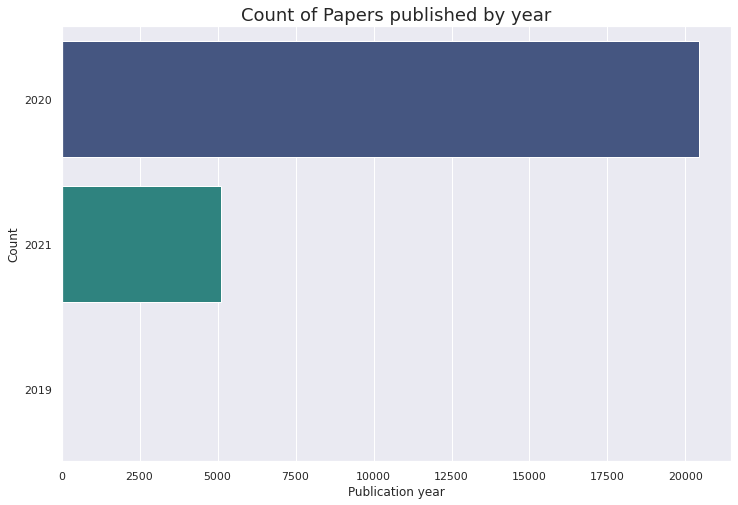

In [ ]:
# publication by year
x,y = df_covid.publish_year.value_counts().index, df_covid.publish_year.value_counts().values 
sns.set(rc={'figure.figsize':(12,8)})
plt.title("Count of Papers published by year", fontdict={'size': 18})
plt.xlabel("Publication year")
plt.ylabel("Count")
sns.barplot(y,x, palette = 'viridis')
plt.show()

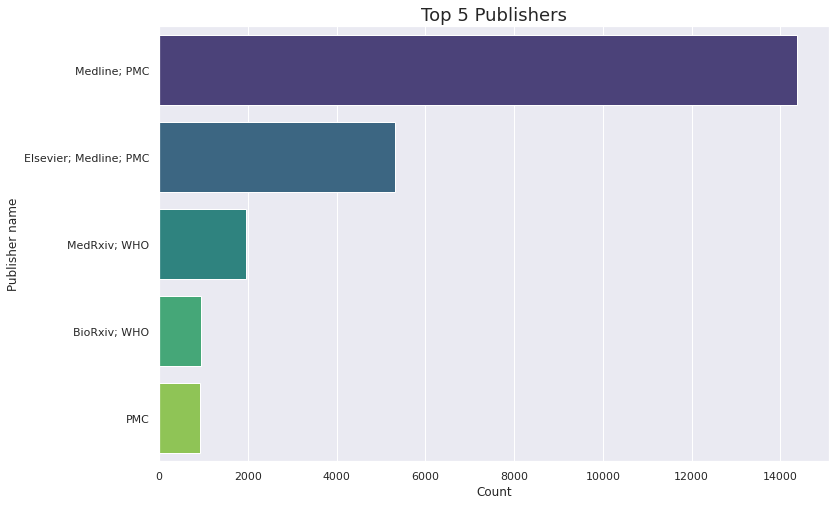

In [ ]:
# publication by year
x,y = df_covid.source_x.value_counts().head(5).index, df_covid.source_x.value_counts().head(5).values 
sns.set(rc={'figure.figsize':(12,8)})
plt.title("Top 5 Publishers", fontdict={'size': 18})
plt.xlabel("Count")
plt.ylabel("Publisher name")
sns.barplot(y,x, palette = 'viridis')
plt.show()

## Cloud of Words

In [ ]:
def create_mask():
    mask = np.array(Image.open("coronavirus.png"))
    im_gray = cv2.cvtColor(mask, cv2.COLOR_BGR2GRAY)
    _, mask = cv2.threshold(im_gray, thresh=20, maxval=10, type=cv2.THRESH_BINARY)
    mask = 255 - mask
    return mask

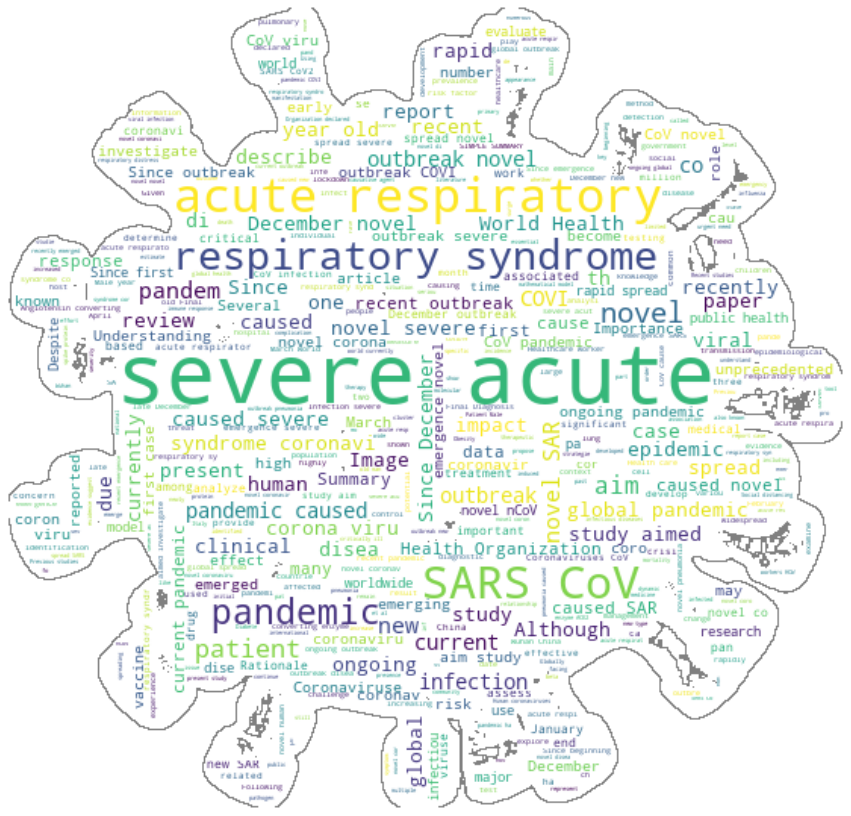

In [ ]:
#helper function to plot words
def plot_words(words, figsize=(15,15)):
  plt.figure(figsize=figsize)
  plt.imshow(words, interpolation='bilinear')
  plt.axis("off")

# remove stop words from text
stop_words = ["OBJECTIVE", "OBJECTIVES", "coronavirus", "see", "text", "disease", 
              "COVID", "PURPOSE", "BACKGROUND", "INTRODUCTION", "ABSTRACT"] + stopwords.words("english")

#initialize wordcloud
cloud = wc(stopwords = stop_words, colormap='viridis', 
           background_color='white', max_words = 1000 , mask =  create_mask(),
           contour_color='grey', contour_width =1, max_font_size = 90, random_state=12)

#generate word cloud
temp = cloud.generate(df_covid.abstract.to_string())

#plot word cloud 
plot_words(temp)

## Cluster Analysis

In [ ]:
def vectorize(text):
  """ Generate vectors for each article in the dataset """
  vectorizer = TfidfVectorizer(max_features=64)
  encoded = vectorizer.fit_transform(text)
  return encoded

In [ ]:
vectorize(df_covid.title.sample(5000).values)

<5000x64 sparse matrix of type '<class 'numpy.float64'>'
	with 33922 stored elements in Compressed Sparse Row format>

In [ ]:
class Cluster:
  def __init__(self, text):
    self.encode_text = vectorize(text)
    self.enc_array = self.encode_text.toarray()
    self.k = 19

  # using tsne apply pca for dimensionality reduction 
  def apply_tsne(self):
    self.t_sne = TSNE(perplexity=30,n_components=2,  random_state=42, init = 'pca')
    self.emb_text = self.t_sne.fit_transform(self.enc_array)
    return self.emb_text

  def apply_pca(self):
    self.pca = PCA(n_components = 0.95, random_state = 42)
    self.reduced = self.pca.fit_transform(self.enc_array)
    return self.reduced

  # unsupersvised learning to cluster text
  def apply_kmeans(self):
    self.reduced_features = self.apply_tsne()
    self.kmeans = KMeans(n_clusters=self.k, tol= 0.001, random_state=42)
    self.clusters = self.kmeans.fit_predict(self.reduced_features)
    return self.clusters

  # make a t-SNE plot of high dimensional data
  def make_plot(self):
    self.tsne = self.apply_tsne()
    self.kmeans = self.apply_kmeans()
    colors = sns.hls_palette(self.k, l=.4, s=.9)
    sns.set(rc={'figure.figsize':(12,12)})
    sns.scatterplot(self.tsne[:,0], self.tsne[:,1], hue=self.kmeans, legend='full', palette=colors)
    plt.title('Kmeans applied to t-SNE data', fontdict={'size': 18})
    return plt.show()

In [ ]:
# cluster text in the title column
data = Cluster(df_covid.title.sample(5000)) # take a random sample of 5000 titles

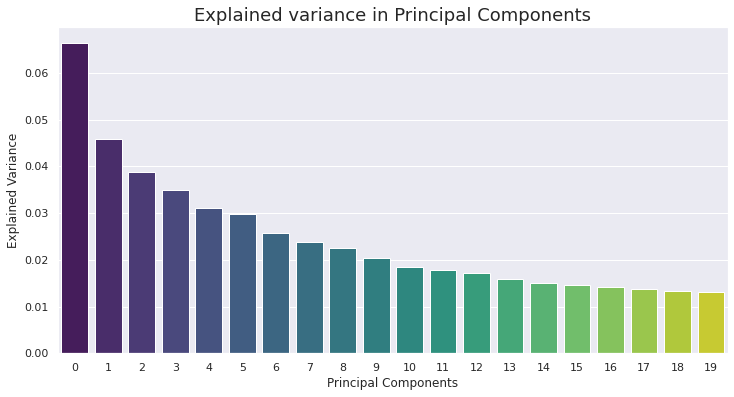

In [ ]:
 data.apply_pca()
pc = [f'{i}' for i in range(len(data.pca.explained_variance_[:20]))]
sns.set(rc={'figure.figsize':(12,6)})
sns.barplot(y=data.pca.explained_variance_[:20], x= pc, palette='viridis')
plt.title("Explained variance in Principal Components", fontdict={'size': 18})
plt.xlabel("Principal Components")
plt.ylabel("Explained Variance")
plt.show()


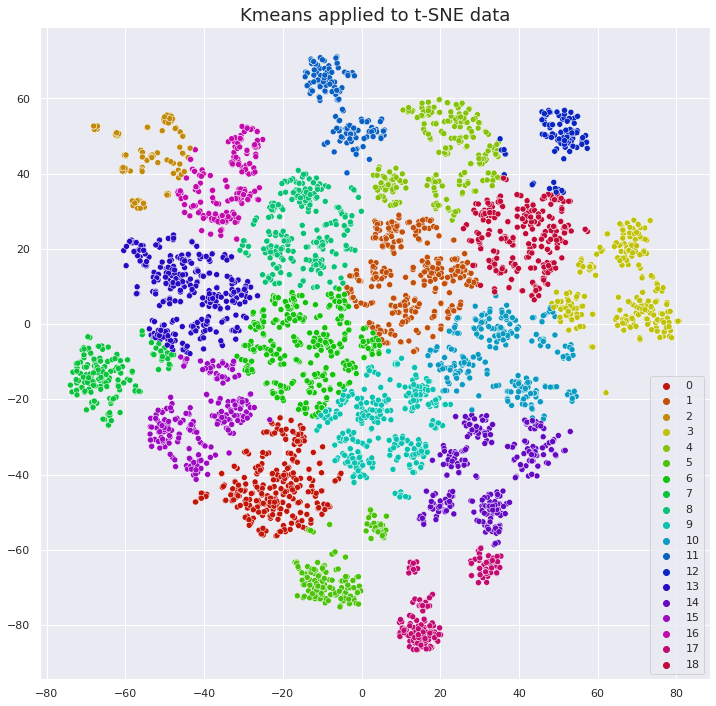

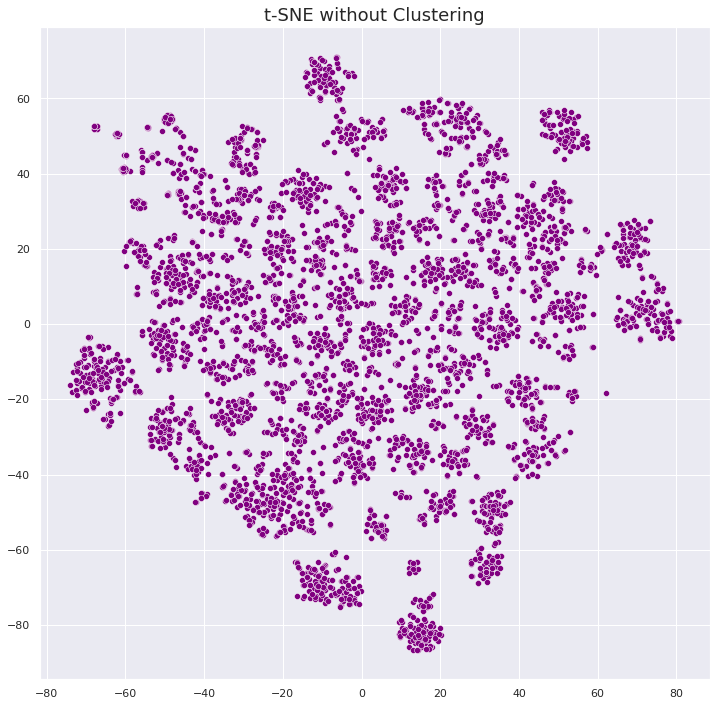

In [ ]:
data.make_plot()
sns.set(rc={'figure.figsize':(12,12)})
palette = sns.color_palette("bright", 1)
sns.scatterplot(data.tsne[:,0], data.tsne[:,1], palette = palette, color='purple')
plt.title('t-SNE without Clustering', fontdict={'size': 18})
plt.show()

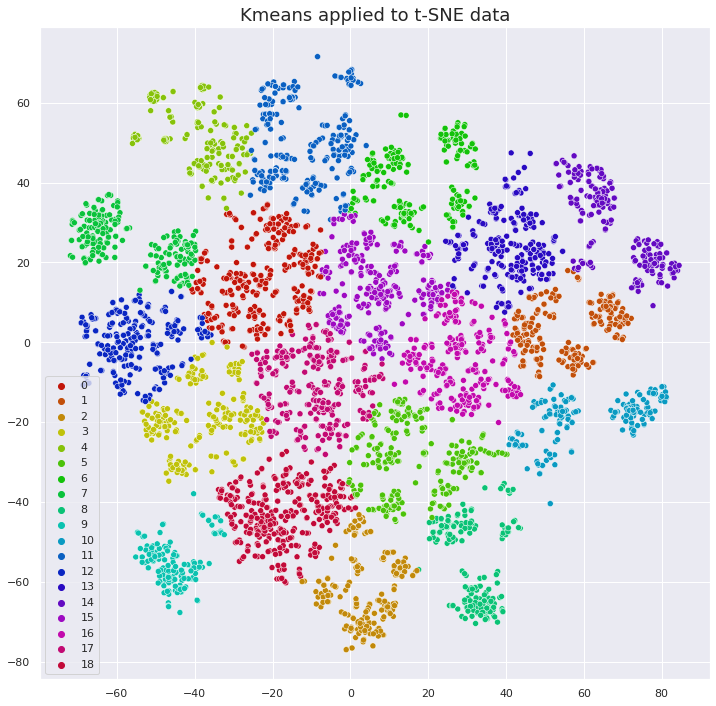

In [ ]:
# cluster text in the title column
data = Cluster(df_covid.title.sample(5000)) # take a random sample of 5000 titles
data.make_plot()


In [ ]:
distortions = []
for k in range(8,30):
  k_means = KMeans(n_clusters=k, random_state=42).fit(data.emb_text)
  m = sum(np.min(cdist(data.emb_text, k_means.cluster_centers_, 'euclidean'), axis=1)) / data.emb_text.shape[0]
  distortions.append(m)
  
print(distortions)

[17.183945045163846, 16.212181489167325, 15.454262118689366, 14.766021432490636, 14.081394213864495, 13.429493384615379, 12.875443143625105, 12.488041786593152, 11.917019661101643, 11.564714102952802, 11.131080284190737, 10.674681408371665, 10.410276094021235, 9.969610969840241, 9.59185083328229, 9.31689244366977, 9.096055565804283, 8.787766418534236, 8.549994931452998, 8.382591511738099, 8.177913488631315, 7.954930576806595]


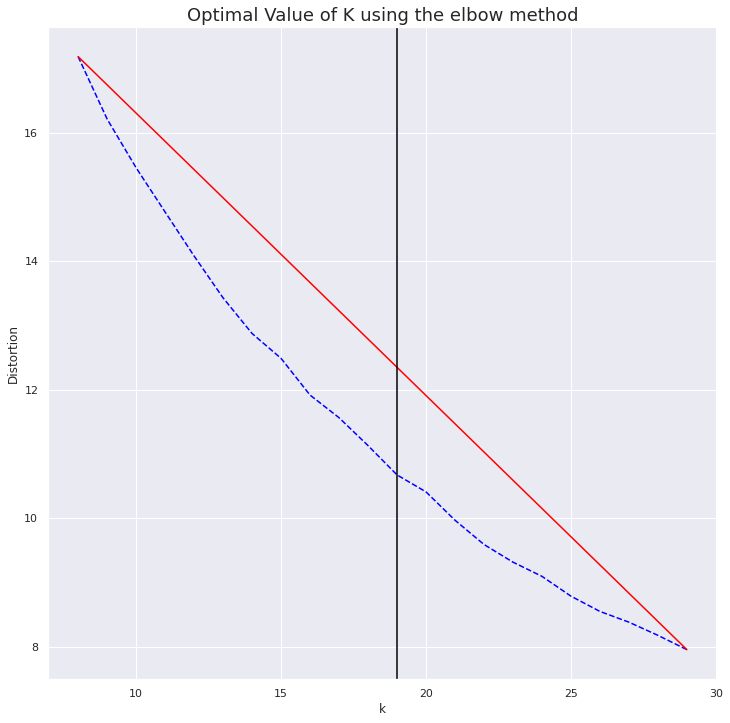

In [ ]:
K = range(8,30)
x_l = [K[0], K[-1]]
y_l = [distortions[0], distortions[-1]]
sns.set(rc={'figure.figsize':(12,12)})
ax = sns.lineplot(K, distortions, color='blue', palette='viridis')
ax2 = sns.lineplot(x_l, y_l, color='red',  palette='viridis')
ax2.lines[0].set_linestyle("--")
plt.axvline(19, color='black')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('Optimal Value of K using the elbow method', fontdict={'size': 18})
plt.show()

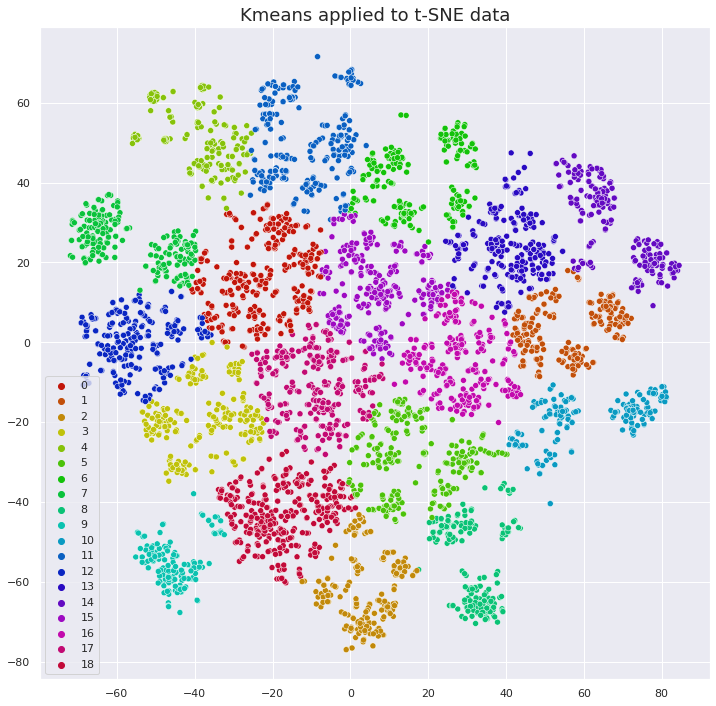

In [ ]:
data.make_plot()

# Model Development

## Helper functions
The following helper functions are defined below

1. **`get_embeddings`**: Returns the embeddings of a sentence using a `Sentence Transformer` token. BERT base mean token has been chosen from the Hugging face transfomers library because it is lightweight and runs quickly. The sentence embeddings would be used to calculate cosimilarity.

2. **`cosine_similarity`**: Returns the cosine similarity between two vecotrs. This function calls the `get_embeddings` function to get the embeddings of the `question` asked and the `context`. Using the `scipy.spatial.distance.cdist` method the `cosine` similarity is computed. Finally, the function returns the rankings of similar documents to a given query. 

In [ ]:
def get_embeddings(text):
  """ Get embeddings for text using sentence bert """
  sentence_embedder = SentenceTransformer('bert-base-nli-stsb-mean-tokens')
  return sentence_embedder.encode(text)

In [ ]:
def cosine_similarity(question, context):
  """ Compute cosine similarity between the question and samples in the context """
  
  # get sentence embeddings for question and context
  question_embeddings, context_embeddings = get_embeddings([question]), get_embeddings(context)

  # get pairwise distances using cosine similarity metric
  dist_matrix = cdist(question_embeddings, context_embeddings, "cosine")[0]

  distances = enumerate(dist_matrix) # give indexes to each cosine similarity score
  similarity_scores = sorted(distances, key=lambda i: i[1]) # sort cosine similarity scores by scores

  return similarity_scores

## Information Retrieval

Two steps are taken to retrieve the relevant set of documents to a given natural language query. These are performed using the `InfoRetrieval` and `BERTRetrieval` classes:

###  InfoRetrieval  

Retrieve similar articles to the question asked using the  `cosine_similarity`  between the article and all the `titles` in the document. This step is performed with the  `similarity_filter`  function. This returns a new dataframe with only the top x similar articles. Where \\[ 0 < x < len(documents)\\]


The `InfoRetrieval`  class uses the `get_documents_filter` to call the `similarity_filter`  and returns the relevant articles.   

  **Notes**
  1. Due to computational limitations (RAM and CPU) the cosine similairty is calculated using the titles and not the body text.
  2. The `InfoRetrieval` class forms the first stage of the Information Retrieval process in this project and is inherited by the `BERTRetrieval` class


In [ ]:
def similarity_filter(question, context = df_covid.title.to_list(), x = 100):

  """ 
  Takes in a question and returns the top n similar articles to the query, using the title of the article as a reference
  """

  all_ids = df_covid.paper_id.to_list() # get ids of all papers in the dataset
  all_titles = df_covid.title.to_list() # get titles of all papers in the dataset
  all_abstracts = df_covid.abstract.to_list() # get abstracts of all papers in the dataset
  all_urls = df_covid.url.to_list() 

  similarity_scores = cosine_similarity(question, context) # return the index and scores of similar vectors in descending order
  similarity_scores = similarity_scores[:x] # select the top n similarities to work with

  # store relevant metadata in a new list
  recommended_ids = [] 
  recommended_titles = []
  best_similarity_scores = []
  recommended_abstracts = []
  recommended_url = []

  # extract the top similar documents from the dataset using the cosine similarity scores 
  for index, distance in similarity_scores:
    similarity_score = round((1-distance),3)
    recommended_ids.append(all_ids[index])
    recommended_titles.append(all_titles[index])
    recommended_url.append(all_urls[index])
    best_similarity_scores.append(similarity_score)
    recommended_abstracts.append(all_abstracts[index])

  # new mapping of info to metadata
  dictionary = {"id": recommended_ids, "title":recommended_titles, 
                "similarity_scores": best_similarity_scores, "abstracts":recommended_abstracts, "url": recommended_url}

  # create new data set from mappings
  similar_articles = pd.DataFrame(dictionary)

  return similar_articles


In [ ]:
class InfoRetrieval:
  def __init__(self, question):
    self.question = question

  def get_similar_documents(self):
    self.relevant_documents = similarity_filter(self.question)
    return self.relevant_documents


### BERTRetrieval  

In this step a pre-trained BERT model is used to extract a relevant answer to a query from the context provided. Here the context is gotten from the InfoRetrieval computed in Step 1. 

The `BERTRetrieval` class inherits from the `InfoRetrieval` class and use the question-answering pipeline from the transformers library to extract an answer from the context provided. `retrieve_answer` returns the excerpt, scores, sorted scores and similar documents. 

A number of pre-trained BERT models are tested:
1. BERT base uncased
2. BioBERT fine-tuned on SQuAD 2.0

These two models have been chosen because of computational limitations available at the time of developing this project.

The comparison of the results from the different pre-trained models form the basis of the Evaluation Protocol for this project.



Configuring the BERT Base model

In [ ]:
# BERT Large Model
bert_base_model = BertForQuestionAnswering.from_pretrained('phiyodr/bert-base-finetuned-squad2')
bert_base_tokenizer = BertTokenizer.from_pretrained('phiyodr/bert-base-finetuned-squad2')

# question-anwering pipeline from hugging face transformers
bert_base_pipe = pipeline('question-answering', model=bert_base_model, tokenizer=bert_base_tokenizer, device =0)

In [ ]:
class BERTRetrieval(InfoRetrieval):

  def __init__(self, question):
    super().__init__(question)
    self.question = question
    self.similar_documents = self.get_similar_documents().head(5)

  def retrieve_answer(self, pipeline):
    self.answers = []
    self.scores = []

    for ix, text in enumerate(self.similar_documents.abstracts):
      # get answer from text using BERT q-a pipeline
      output = pipeline({'question': self.question, 'context':text})
      self.answers.append(output['answer'])
      self.scores.append(output['score'])

    self.ranked_scores = [ix[0] for ix in sorted(enumerate(self.scores), key=lambda score:-score[1])]
    
    return self.answers, self.scores, self.ranked_scores, self.similar_documents

### Sentiment Analysis
The code block beloww implements a sentiment analyis classifier for the abstract columns.

In [ ]:
def sentiment_classifier(title, body):
  """ Find the sentiment of a passage using a pre-trained Text blob model"""
  text = TextBlob(str(title)+" "+str(body))
  if text.sentiment.polarity > 0:
    return "Positive"
  if text.sentiment.polarity < 0:
    return "Negative" 
  if text.sentiment.polarity == 0:
    return "Neutral" 

## Displaying the results

In order to display the results in a user-friendly manner, the `show_results` function is developed to format the output in `HTML` and the excerpts from the `BERTRetrieval` steps are highlited in blue text.

Finally, the `search` function receives an input (research question of interest) and calls the `show_results` function to format the output

In [ ]:
def show_results(question, pipeline, verbose):
  """ Takes in a research question and displays the relevant answers from all documents in the dataset """

  # retrieve answers using two stage information retrieval pipeline
  answers, scores, ranked_scores, relevant_documents =  BERTRetrieval(question).retrieve_answer(pipeline)

  if verbose:
    # format ouput using html
    display(HTML(f"<h1> {question} </h1>"))

  # get title and abstract from relevant documnents
  titles, abstracts, urls = relevant_documents.title, relevant_documents.abstracts, relevant_documents.url
  

  # loop through all documents and get answers
  for i, ix in enumerate(ranked_scores):
    # locate index in 
    title, abstract, answer, score = titles.iloc[ix], abstracts.iloc[ix], answers[ix], round(scores[ix],6)
    
    url = urls[ix].split(';')[0] # get the first url 
    try:
      sentiment = sentiment_classifier(title, abstract)  # get sentiment of the abstract
    except:
      sentiment = "NA"

    if verbose:
      # format output using HTML syntax
      display(HTML(f" <h3> {title} </h3>"))
      highlighted = f'<span style="color: blue; font-weight: bold">{answer}</span>'  # put answer in red font 
      abstract = abstract.replace(answer,highlighted)

      display(HTML(f"<p> <b> Abstract: </b> {abstract}  </p>"))
      display(HTML(f'<span style="color: grey; font-weight: light"> <b> Paper Ranking: </b> {str(i+1)} \
                    <b> Confidence </b>: {str(score)} </span> '))
      display(HTML(f"<p> <b> Read Paper </b>: <a href='{url}'>{url} </a> </p>"))
      display(HTML(f"<p> <b> Sentiment: {sentiment} </b> </p>"))

        
      print()
  if not verbose:   
    return answers

## Inference 

Here a number of different questions are asked related to:
1. Covid-19 risk factors
2. Development of drugs and therapeutics
3. Effectiveness of vaccines
4. Side effect of vaccines.

**Note**
While only these 4 questions have been asked, the model developed is robust and can provide relevant answers to any question per-taining to Covid-19.


### BERT Base Model
The outputs below are the the BERT Large uncased model which has the following features:
12-layers, 768 hidden dimension, 12 attention heads, and 110M parameters.


In [ ]:
def search(question, pipeline = bert_base_pipe, verbose = True):
  return show_results(question, pipeline, verbose)

In [ ]:
search("How effective are COVID-19 vaccines in the world today ?")

Some weights of the model checkpoint at /root/.cache/torch/sentence_transformers/sbert.net_models_bert-base-nli-stsb-mean-tokens/0_BERT were not used when initializing BertModel: ['classifier.weight', 'classifier.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of the model checkpoint at /root/.cache/torch/sentence_transformers/sbert.net_models_bert-base-nli-stsb-mean-tokens/0_BERT were not used when initializing BertModel: ['classifier.weight', 'classifier.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task

In [ ]:
search("What are the approaches to evaluate risk for enhanced diseases after vaccination")

Some weights of the model checkpoint at /root/.cache/torch/sentence_transformers/sbert.net_models_bert-base-nli-stsb-mean-tokens/0_BERT were not used when initializing BertModel: ['classifier.weight', 'classifier.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of the model checkpoint at /root/.cache/torch/sentence_transformers/sbert.net_models_bert-base-nli-stsb-mean-tokens/0_BERT were not used when initializing BertModel: ['classifier.weight', 'classifier.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task

In [ ]:
search("What are the side effects of COVID-19 vaccines ?")

Some weights of the model checkpoint at /root/.cache/torch/sentence_transformers/sbert.net_models_bert-base-nli-stsb-mean-tokens/0_BERT were not used when initializing BertModel: ['classifier.weight', 'classifier.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of the model checkpoint at /root/.cache/torch/sentence_transformers/sbert.net_models_bert-base-nli-stsb-mean-tokens/0_BERT were not used when initializing BertModel: ['classifier.weight', 'classifier.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task

### BioBERT Model
The outputs below are the the BERT Large uncased model which has the following features:

Configuring the BioBERT model

In [ ]:
# BioBERT Model
biobert_model = BertForQuestionAnswering.from_pretrained('ktrapeznikov/biobert_v1.1_pubmed_squad_v2')
biobert_tokenizer = BertTokenizer.from_pretrained('ktrapeznikov/biobert_v1.1_pubmed_squad_v2') 

# question-anwering pipeline from hugging face transformers
biobert_pipe = pipeline('question-answering', model=biobert_model, tokenizer=biobert_tokenizer, device =0)

In [ ]:
def search(question, pipeline = biobert_pipe, verbose = True):
  return show_results(question, pipeline, verbose)

In [ ]:
search("How effective are COVID-19 vaccines in the world today ?")

Some weights of the model checkpoint at /root/.cache/torch/sentence_transformers/sbert.net_models_bert-base-nli-stsb-mean-tokens/0_BERT were not used when initializing BertModel: ['classifier.weight', 'classifier.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of the model checkpoint at /root/.cache/torch/sentence_transformers/sbert.net_models_bert-base-nli-stsb-mean-tokens/0_BERT were not used when initializing BertModel: ['classifier.weight', 'classifier.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task

In [ ]:
search("What are the approaches to evaluate risk for enhanced diseases after vaccination")

Some weights of the model checkpoint at /root/.cache/torch/sentence_transformers/sbert.net_models_bert-base-nli-stsb-mean-tokens/0_BERT were not used when initializing BertModel: ['classifier.weight', 'classifier.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of the model checkpoint at /root/.cache/torch/sentence_transformers/sbert.net_models_bert-base-nli-stsb-mean-tokens/0_BERT were not used when initializing BertModel: ['classifier.weight', 'classifier.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task

# Evaluation Protocol
In this project the models and performance would be evaluated based on the three metrics below:
1. Speed: Runtime and Inference time
2. Relevance: How relevant are the top n recommended questions to the query

In [ ]:
# def measure_runtime(pipe):

#   question_list = ["How effective are COVID-19 vaccines in the world today ?", 
#                    "What are the approaches to evaluate risk for enhanced diseases after vaccination",
#                    "How effective are COVID-19 vaccines in the world today ?"]

#   execution_times = []

#   for question in tqdm(question_list):
#     start_time = time.clock()
#     search(question, pipeline = pipe, verbose = False) 
#     total_time = time.clock() - start_time
#     execution_times.append(total_time)

#   avg_time = sum(execution_times)/len(execution_times)
#   results = {"time": avg_time, "executions": execution_times}
#   return results


In [ ]:
def performance_report(pipe):

  """ Computes similarity of start and end tokens with question asked """
  
  question_list = ["How effective are COVID-19 vaccines in the world today ?", 
                   "What are the approaches to evaluate risk for enhanced diseases after vaccination",
                   "How effective are COVID-19 vaccines in the world today ?"]

  relevance_scores = []
  execution_times = []
  start_time = time.clock()

  for question in tqdm(question_list):
   
    answers = search(question, pipe, False)
    total_time = time.clock() - start_time
    execution_times.append(total_time)

    for answer in answers:
      score = np.sum(get_embeddings(question)*get_embeddings(answer)) / (np.sqrt(np.sum(np.square(get_embeddings(question))))*np.sqrt(np.sum(np.square(get_embeddings(answer)))))
      relevance_scores.append(score)

  avg_time = sum(execution_times)/len(execution_times)
  avg_relevance_score = sum(relevance_scores)/len(relevance_scores)

  results = {"scores" : relevance_scores, "relevance" : avg_relevance_score}, {"time": avg_time, "executions": execution_times}
  return results

In [ ]:
bert_base_relevance_score, bert_base_run_time = performance_report(bert_base_pipe)

100%|██████████| 3/3 [08:31<00:00, 170.50s/it]


In [ ]:
biobert_relevance_score, biobert_run_time = performance_report(biobert_pipe)

100%|██████████| 3/3 [08:24<00:00, 168.33s/it]


In [ ]:
def percentage_diff(score_1, score_2):
  """ Helper function to calculate percentage difference between a pair of scores """
  delta = score_1 - score_2
  percentage_d = delta/score_1 * 100
  return percentage_d

### Runtime

In [ ]:
per_delta =  percentage_diff(bert_base_run_time['time'], biobert_run_time['time'])
print(f"BERT base is {per_delta}% faster than BioBERT")

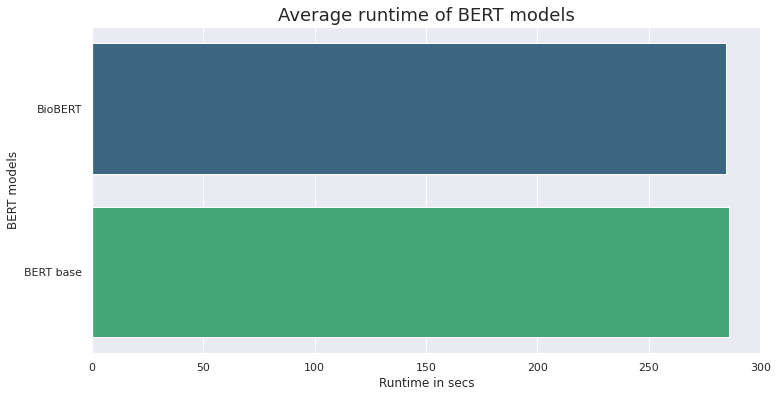

In [ ]:
sns.set(rc={'figure.figsize':(12,6)})
sns.barplot(x=[biobert_run_time["time"], bert_base_run_time["time"]], y =['BioBERT', 'BERT base'], palette='viridis')
plt.title("Average runtime of BERT models", fontdict={'size': 18})
plt.ylabel("BERT models")
plt.xlabel("Runtime in secs")
plt.show()

The average runtime for both BERT models are centred around 59 seconds, however it is observed that the BERT model achieced a slightly lower runtime of xx seconds

In [ ]:
runtime_df = pd.DataFrame({"Model" : ["BERT Base"]*3 + ["BioBERT"]*3,
                      "Run tume" : bert_base_run_time["executions"] + biobert_run_time["executions"]})

In [ ]:
runtime_df

,Model,Run tume
0,BERT Base,114.751314
1,BERT Base,284.877171
2,BERT Base,458.891294
3,BioBERT,114.247092
4,BioBERT,284.916705
5,BioBERT,454.720659


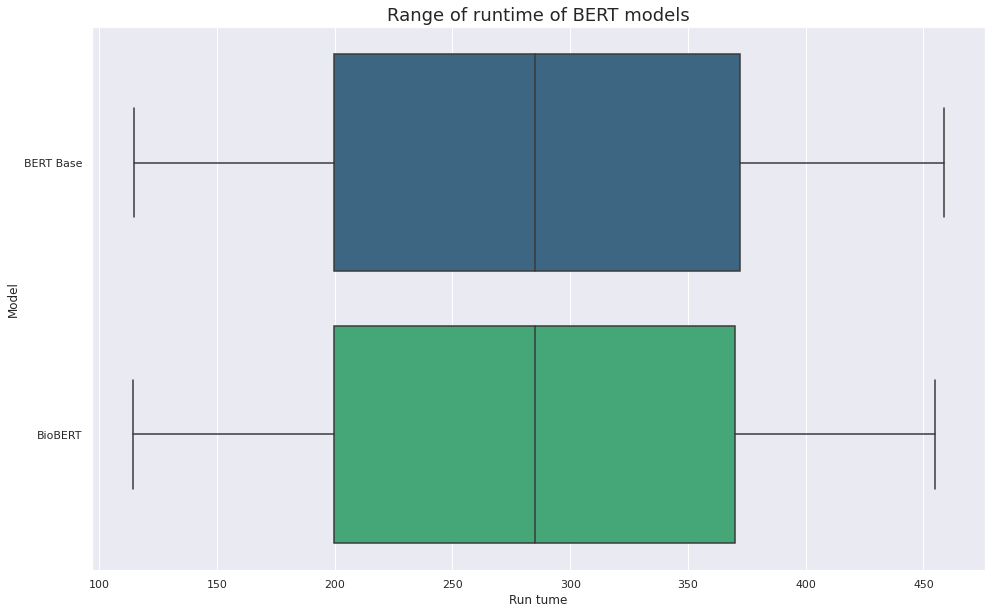

In [ ]:
plt.title("Range of runtime for both BERT models", fontdict={'size': 18})
sns.set(rc={'figure.figsize':(16,10)})
sns.boxplot(y = "Model",x = "Run tume", data= runtime_df, palette='viridis')
plt.show()

### Relevance Score

In [ ]:
per_delta =  percentage_diff(bert_base_relevance_score['relevance'], biobert_relevance_score['relevance'])
print(f"BioBERT achieved a {per_delta}% higher relevance score than BERT base on the relevance score test")

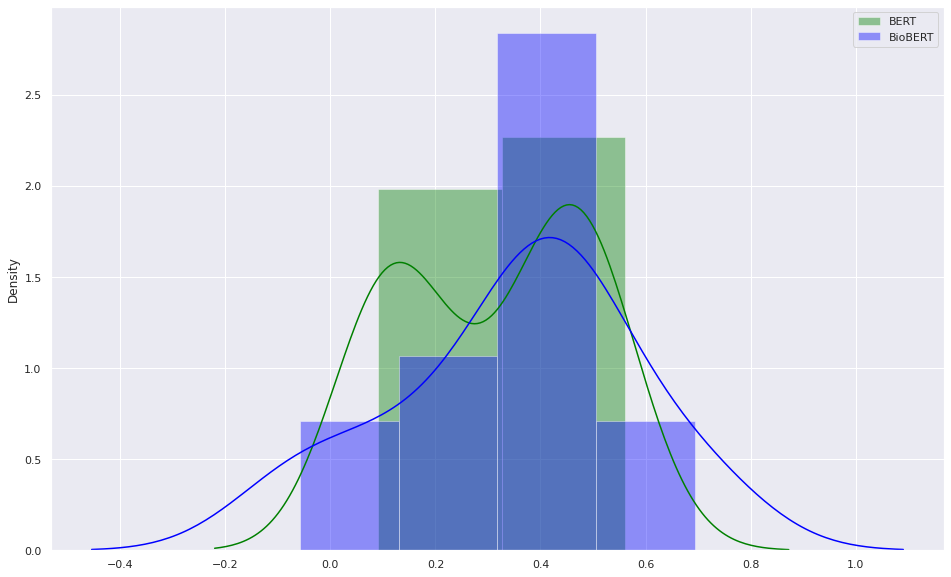

In [ ]:
sns.violinplot(bert_base_relevance_score['scores'], kde=True,label = 'BERT', color = 'blue')
sns.violinplot(biobert_relevance_score['scores'], kde=True,label = 'BioBERT', color = 'green')
plt.title("Relevance Scores for BERT and BioBERT models")
plt.legend()
plt.show()